In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gc
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image 
from IPython.display import display
import timm
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
tqdm.pandas()

In [5]:
SEED = 23
targets = ['real_weight', 'real_width', 'real_height', 'real_length']
TRAIN_IMG_DIR = '/kaggle/input/aaa-ml-final-project/train/train'
TEST_IMG_DIR  = '/kaggle/input/aaa-ml-final-project/test/test'
BATCH_SIZE = 32         
IMG_SIZE = 380           
MODEL_NAME = 'tf_efficientnet_b4_ns'
TEXT_MODEL = 'cointegrated/rubert-tiny2'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

Device: cuda


In [6]:
train_df = pd.read_parquet('/kaggle/input/aaa-ml-final-project/train.parquet')
test_df = pd.read_parquet('/kaggle/input/aaa-ml-final-project/test.parquet')

In [7]:
train_df['full_text'] = train_df['title'].fillna('') + " " + train_df['description'].fillna('')
test_df['full_text'] = test_df['title'].fillna('') + " " + test_df['description'].fillna('')

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape:  {test_df.shape}")

train_df.head()

Train Shape: (312908, 17)
Test Shape:  (70274, 13)


,item_id,order_date,item_condition,item_price,category_name,subcategory_name,microcat_name,seller_id,buyer_id,title,description,image_name,real_weight,real_height,real_length,real_width,full_text
0,185689,2024-09-27,Б/у,3000.0,Транспорт,Запчасти и аксессуары,Салон,1942218,1935418,Ручка АКПП mercedes w203 avangarde,Ручка рычаг акпп на Мерседес В203 mercedes w203 avangarde в хорошем состоянии \n\nОтправлю транс...,185689.jpg,0.370,10.0,23.0,19.0,Ручка АКПП mercedes w203 avangarde Ручка рычаг акпп на Мерседес В203 mercedes w203 avangarde в х...
1,1914373,2024-11-07,Новое с биркой,5990.0,Личные вещи,"Одежда, обувь, аксессуары",Зимние куртки и пуховики,2164034,1753243,Пуховик Moncler голубой (52 размер),Объявление для заказа 📲\n\nАвито доставка 🚚\n\nПуховик Moncler голубой\n\n52 размер,1914373.jpg,2.486,14.0,37.0,24.0,Пуховик Moncler голубой (52 размер) Объявление для заказа 📲\n\nАвито доставка 🚚\n\nПуховик Moncl...
2,361626,2024-12-15,Новое,1200.0,Транспорт,Запчасти и аксессуары,Двигатель,621511,1233378,Запчасти на ford фокус1,"Опора задняя,двигатель w тигуан 1,4 150 б.у",361626.jpg,0.640,7.0,23.0,18.0,"Запчасти на ford фокус1 Опора задняя,двигатель w тигуан 1,4 150 б.у"
3,534927,2024-01-20,Б/у,13000.0,Электроника,"Игры, приставки и программы",Игровые приставки и аксессуары,998450,1082324,Ps3 cechc 08 скальпирована HEN(полностью исправна),"В комплекте приставка, провода(зарядка, питание, hdmi) работает тихо даже в игре( не больше 51дб...",534927.jpg,7.100,20.0,35.0,20.0,"Ps3 cechc 08 скальпирована HEN(полностью исправна) В комплекте приставка, провода(зарядка, питан..."
4,199043,2024-07-28,Отличное,300.0,Личные вещи,"Одежда, обувь, аксессуары","Джемперы, свитеры, кардиганы",528098,477834,Свитер трикотаж 44 р-р Reserved,Свитер Pull&Bear (пул энд бир)\n44 размер\nНадела один раз\n\nПримерные размеры:\nШирина: 45 см\...,199043.jpg,0.400,7.0,23.0,11.0,Свитер трикотаж 44 р-р Reserved Свитер Pull&Bear (пул энд бир)\n44 размер\nНадела один раз\n\nПр...


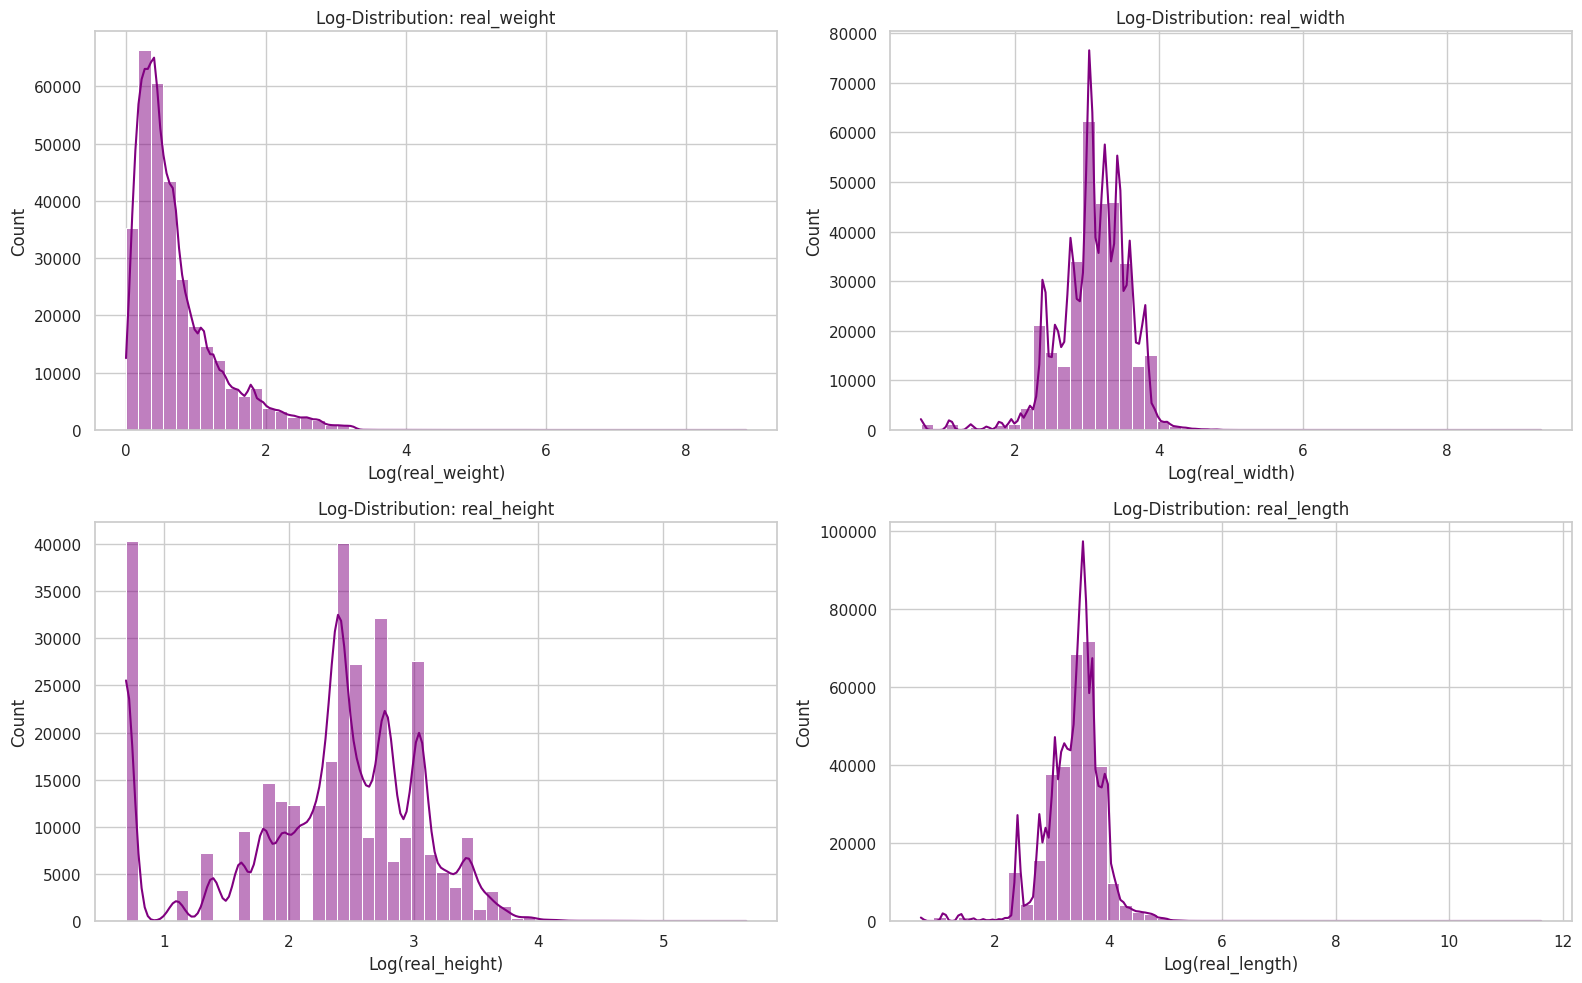

In [8]:
# Plots таргетов

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(targets):
    sns.histplot(np.log1p(train_df[col]), kde=True, ax=axes[i], color='purple', bins=50)
    axes[i].set_title(f'Log-Distribution: {col}')
    axes[i].set_xlabel(f'Log({col})')

plt.tight_layout()
plt.show()
# на самом деле видно что есть пики на некоторых значениях (круглые и кратные 5), но это нам не особо помогает)

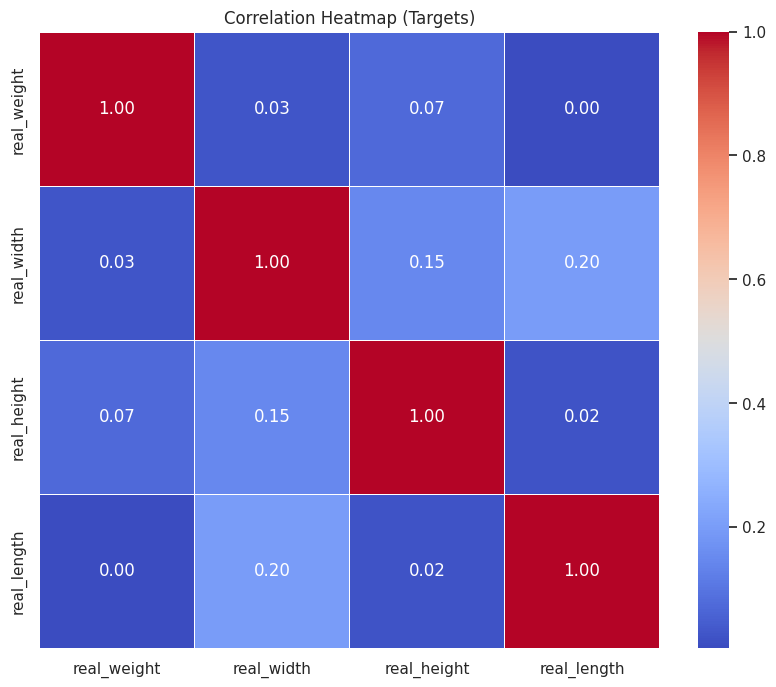

In [9]:
# Heatmap
plt.figure(figsize=(10, 8))
numeric_cols = targets
corr_matrix = train_df[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Targets)")
plt.show()

# корреляции особо нет(

In [10]:
def visualize_sample(df=train_df, index=None, img_dir=TRAIN_IMG_DIR):
    if index not in df.index:
        print(f"Индекс {index} не найден.")
        return
    sample_row = df.loc[[index]]
    idx = index
    
    row = sample_row.iloc[0]
    img_name = row['image_name']
    
    print(f"=== Объект ID: {idx} ===")
    
    pd.set_option('display.max_colwidth', None)
    
    cols_to_show = ['title', 'description', 'microcat_name', 'item_price', 
                    'real_weight', 'real_width', 'real_height', 'real_length']
    
    display(sample_row[cols_to_show].T)
    
    full_img_path = os.path.join(img_dir, img_name)
    
    image = Image.open(full_img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"File: {img_name}")
    plt.show()

=== Объект ID: 122 ===


,122
title,Аккумуляторный шуруповёрт Hilti SD 5000-A22
description,Инструмент почти новый не пользовались\n\nБез аккумуляторов
microcat_name,Дрели и шуруповёрты
item_price,10000.0
real_weight,1.94
real_width,20.0
real_height,15.0
real_length,30.0


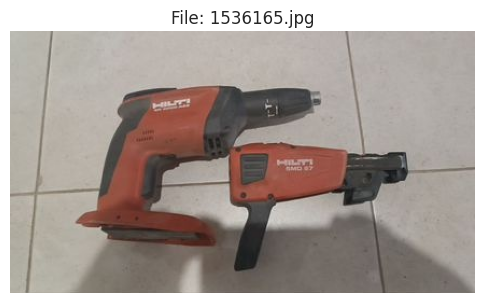

In [11]:
visualize_sample(index=122)

# Регулярки

In [12]:
def extract_features_smart(text, microcat):    
    text = text.lower().replace('х', 'x').replace('x', 'x')
    
    # weight
    weight = -1
    
    dangerous_cats = [
        'Дайвинг и водный спорт', 
        'Товары для купания', 
        'Постельные принадлежности',
        'Нательные комбинезоны'
    ]
    
    if microcat not in dangerous_cats:
        rev_mult = re.search(r'(\d+[.,]?\d*)\s*(?:кг|kg)\s*(?:\*|x|х)\s*(\d+)\b', text)
        if rev_mult:
            val = float(rev_mult.group(1).replace(',', '.'))
            qty = float(rev_mult.group(2))
            if 1 < qty <= 20 and val <= 30:
                weight = val * qty

        if weight == -1:
            mult_match = re.search(r'(\d+)\s*(?:по|х|x|шт)\s*(\d+[.,]?\d*)\s*(?:кг|kg)\b', text)
            if mult_match:
                qty = float(mult_match.group(1))
                val = float(mult_match.group(2).replace(',', '.'))
                if 1 < qty <= 20 and val <= 30:
                    weight = qty * val
        
        if weight == -1:
            for match in re.finditer(r'(\d+[.,]?\d*)\s*(?:кг|kg)\b', text):
                val = float(match.group(1).replace(',', '.'))

                start_pos = match.start()
                
                context_before = text[max(0, start_pos-10):start_pos]
                
                if any(w in context_before for w in ['до ', 'от ', 'для ', 'на ']):
                    continue
                
                if val <= 10: 
                    weight = val
                    
                    if any(w in text for w in ['пара', 'два ', 'две ', 'цена за обе']):
                        weight *= 2
                    break

    # diagonal
    diag_match = re.search(r'(\d+[.,]?\d*)\s*(?:"|”|дюйм)', text)
    diagonal = -1
    if diag_match:
        val = float(diag_match.group(1).replace(',', '.'))
        if 4 <= val <= 100: diagonal = val

    # dims
    dim_match = re.search(r'(\d+[.,]?\d*)\s*[:x*]\s*(\d+[.,]?\d*)\s*[:x*]\s*(\d+[.,]?\d*)', text)
    dims = [-1, -1, -1]
    if dim_match:
        found_dims = [float(x.replace(',', '.')) for x in dim_match.groups()]
        found_dims.sort()
        if max(found_dims) < 3000 and max(found_dims) > 0:
            if max(found_dims) > 400: found_dims = [d / 10 for d in found_dims]
            elif found_dims[2] > 1000 and found_dims[1] > 500: found_dims = [-1, -1, -1]
            dims = found_dims

    return pd.Series(dims + [weight, diagonal], index=['txt_dim1', 'txt_dim2', 'txt_dim3', 'txt_weight', 'txt_diagonal'])

In [13]:
def analyze_regex_failures(df, top_n_cats=5):
    mask = df['txt_weight'] > 0
    reg_df = df[mask].copy()
    
    reg_df['err_kg'] = abs(reg_df['txt_weight'] - reg_df['real_weight'])
    
    cat_stats = reg_df.groupby('microcat_name').agg({
        'err_kg': 'mean',
        'item_id': 'count'
    }).rename(columns={'item_id': 'count_found'})
    
    cat_stats = cat_stats[cat_stats['count_found'] > 5]
    
    worst_cats = cat_stats.sort_values('err_kg', ascending=False).head(10)
    
    print(f"{'Microcategory':<35} | {'Found':<5} | {'Avg Error (kg)':<15}")
    print("-" * 65)
    for cat, row in worst_cats.iterrows():
        print(f"{cat:<35} | {row['count_found']:<5} | {row['err_kg']:<15.2f}")
    
    return worst_cats.index.tolist(), reg_df

In [14]:
# Парсим
train_data = [extract_features_smart(t, c) for t, c in zip(train_df['full_text'], train_df['microcat_name'])]
train_feats = pd.DataFrame(train_data, index=train_df.index)
train_df = pd.concat([train_df, train_feats], axis=1)

test_data = [extract_features_smart(t, c) for t, c in zip(test_df['full_text'], test_df['microcat_name'])]
test_feats = pd.DataFrame(test_data, index=test_df.index)
test_df = pd.concat([test_df, test_feats], axis=1)

In [15]:
worst_categories, reg_df_with_err = analyze_regex_failures(train_df)

Microcategory                       | Found | Avg Error (kg) 
-----------------------------------------------------------------
Аксессуары для фитнеса              | 21.0  | 7.16           
Рюкзаки и экипировка                | 6.0   | 4.75           
Музыкальные центры, магнитолы       | 52.0  | 3.72           
Фитнес и тренажёры                  | 83.0  | 3.49           
Уход и гигиена                      | 22.0  | 3.49           
Чемоданы и дорожные сумки           | 26.0  | 3.49           
Видео, DVD и Blu-ray плееры         | 9.0   | 3.27           
Наборы инструментов                 | 12.0  | 3.05           
Аксессуары                          | 56.0  | 3.03           
Акустика, колонки, сабвуферы        | 42.0  | 3.02           



КАТЕГОРИЯ: Аксессуары для фитнеса

=== Объект ID: 181635 ===


,181635
title,Бодибар 6 кг
description,"Продаю 2 бодибаров неопреновых, вес одного 6 кг, фирма STARFIT. Приобретала в зал, использовались аккуратно, все целые. Продаю, нужен вес больше.\nПокупала на WB.\n\nМожно отдельно, цена за один 1500₽."
microcat_name,Аксессуары для фитнеса
item_price,7000.0
real_weight,89.7
real_width,45.0
real_height,36.0
real_length,372.0


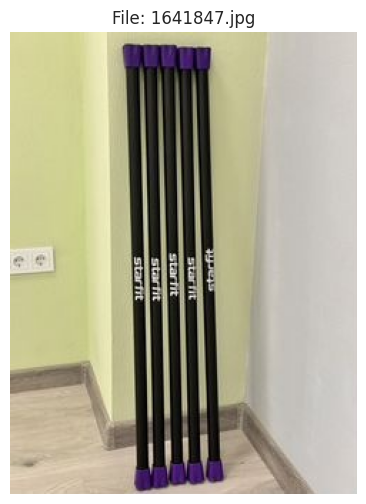

=== Объект ID: 278477 ===


,278477
title,Мячик для фитнеса
description,"Продаются мячи для фитнеса 5кг, пользовались только в зале бокса, цена вопроса 1200 за 1шт."
microcat_name,Аксессуары для фитнеса
item_price,6000.0
real_weight,19.15
real_width,37.0
real_height,35.0
real_length,37.0


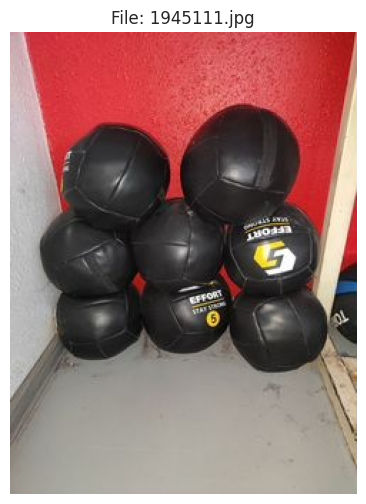

=== Объект ID: 186305 ===


,186305
title,Медбол 5 оранжевых (2кг) 1 Жёлтый (1кг)
description,В отличном состоянии.\n1500 за каждый мяч. \nПо 1000 если все сразу.
microcat_name,Аксессуары для фитнеса
item_price,6000.0
real_weight,12.4
real_width,43.0
real_height,40.0
real_length,47.0


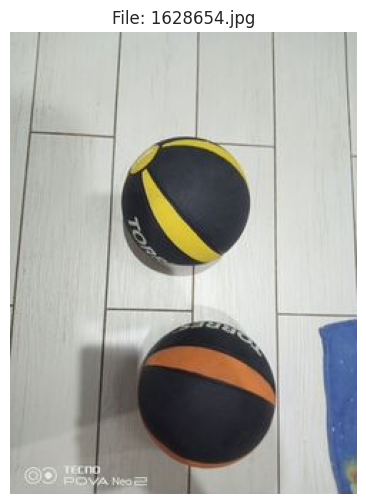


КАТЕГОРИЯ: Рюкзаки и экипировка

=== Объект ID: 9963 ===


,9963
title,Рюкзак туристический Nova Your Yukon 95
description,"Продаётся туристический рюкзак, б/у, объём 95л, вес 2,8 кг. \nРюкзак двухкамерный. \nПодвесная система ABS V. 1"
microcat_name,Рюкзаки и экипировка
item_price,2700.0
real_weight,16.8
real_width,35.0
real_height,30.0
real_length,80.0


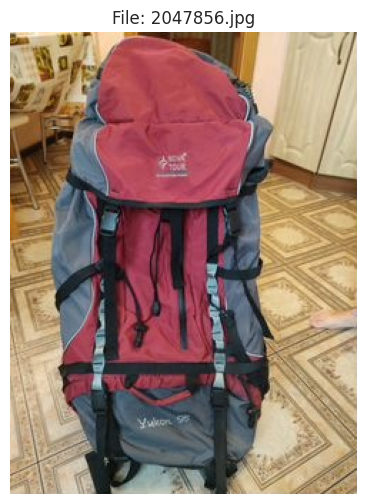

=== Объект ID: 54218 ===


,54218
title,Сумка для рыбалки ZuCa
description,"Продается сумка на колесах для рыбалки,туризма, пляжного отдыха фирмы ZUCA, новая, дешевле, чем на сайте.Положите в сумку All-Terrain все вещи, которые понадобятся Вам в прогулке по пересеченной местности, на рыбалке, на пляже или на поле для гольфа. Благодаря большим бескамерным колесам, которые легко снимаются/одеваются на раму, этот ""вездеход"" успешно передвигается по любой местности, а вместительная моющаяся тканевая часть сумки требует минимальных усилий по уходу за ней. И, самое главное, на сумке можно комфортно сидеть с весом до 136 кг! Это ли не подспорье рыбакам?\n\nПрочная запатентованная рама является мобильным сиденьем, на котором можно безопасно и комфортно сидеть с весом до 136 кг.\nПередняя часть сумки (дверца на молнии) легко открывается и прячется, чтобы не создавать помех для доступа к содержимому.\nСлева сумка имеет дополнительную боковую дверцу для обеспечения еще большего удобства при загрузке и выгрузке вещей.\nСъёмная, моющаяся тканевая основа сумки сделана из водоотталкивающего полиэстера высшего качества.\nБлагодаря 30-сантиметровым колесам с большим протектором сумка успешно катится по камням, песку, снегу, неровной дороге. Вы практически не ограничены в выборе места и времени для путешествия.\nСъемные колеса обеспечивают компактность сумки, поэтому она не займет много места при ее транспортировке и хранении. Снять и одеть колеса очень быстро и легко.\nГерметичные спрятанные подшипники на колесах сводят к минимуму уход за ними и обеспечивают плавность хода.\nПолучайте удовольствие от использования регулируемых держателей для бутылок с любимыми напитками.\nСумка имеет 125 см телескопическую ручку.\nЭта сумка не соответствует требованиям, предъявляемым к ручной клади.\nВес сумки — 5,76 кг\nРазмеры (см): высота — 60; ширина — 25,5; глубина — 33,5 (с ручкой - 37)\nРазмеры с колесами (см): высота — 60; ширина — 54; глубина — 48,5\nВнутренние размеры (см): высота — 46; ширина — 24; глубина — 33\nВысота с выдвинутой ручкой (см) — от 96 до 125.\nВместительность — 36 литров"
microcat_name,Рюкзаки и экипировка
item_price,22000.0
real_weight,17.503
real_width,39.0
real_height,34.0
real_length,66.0


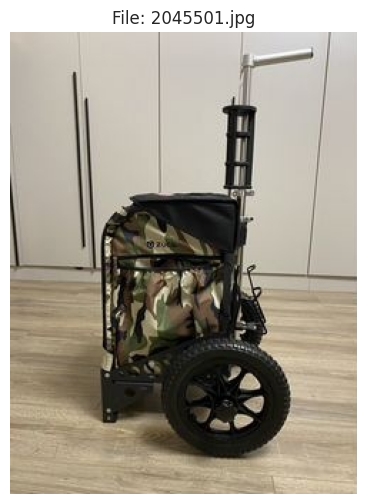

=== Объект ID: 254040 ===


,254040
title,Туристический рюкзак tramp sigurd 60+10
description,"Был куплен но никогда не использовался!!!\nС этикетками, чистый и т.д.\n\nобмен на ,что-то интересует. \nторг присутствует. \n\nТуристический рюкзак\nХарактеристики:\n—объем: 60 + 10 л\n—размер: 63 * 28 * 25 см + капюшон\n—вес: 1,9 кг\n—материал: нейлон Rip Stop 420D + 600D\n—Рюкзак для длительных походов, с двумя отделениями, внутренняя перегородка на молнии\n—Два внешних кармана и дополнительный карман на капюшоне\n—Два кармана на резинках по сторонам \n—Два кармана на поясной обвязке\n—Карман на дне рюкзака с дождевиком\n—Мягкий съемный анатомический пояс с дополнительными карманами\n—Подвесная ABS система позволяет подгонять рюкзак под разный рост\n—Анатомические плечевые ремни\nПроизводитель: ТМ Tramp\nСтрана производитель: Россия\nВ наличии только один рюкзак."
microcat_name,Рюкзаки и экипировка
item_price,5700.0
real_weight,2.14
real_width,33.0
real_height,13.0
real_length,68.0


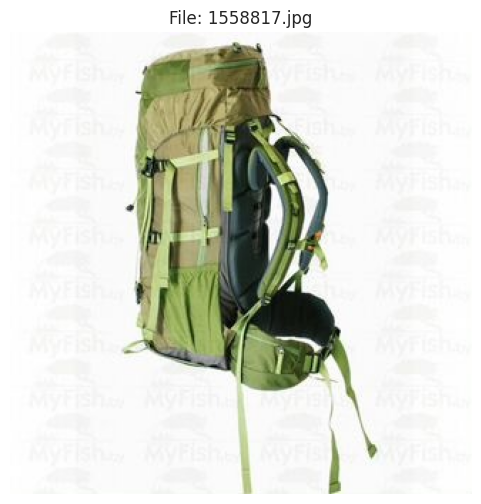


КАТЕГОРИЯ: Музыкальные центры, магнитолы

=== Объект ID: 127425 ===


,127425
title,Trio KP-7300
description,"только что из Японии. без пробега по России. хорошее состояние. продаётся с шеллом и иглой. питание 100 вольт. в наличии много винтажной аудиотехники из Японии. смотрите карточку продавца. \n\nПроигрыватель был разработан с целью получения информации, выгравированной на диске, как она есть.\n\nСекция поворотной платформы ориентирована на кратковременные колебания нагрузки, которые не могут контролироваться только с помощью сервосхемы, и в ней используется сверхмощная поворотная платформа диаметром 330 мм, весом 2,6 кг и готовой массой 440 кг см 2 (включая резиновый лист). ). Благодаря использованию этого проигрывателя с 20-полюсным двигателем с 30 пазами и чрезвычайно низкими пульсациями крутящего момента также подавляется переходная нагрузка, возникающая, когда звукосниматель прослеживает звуковую канавку с большим динамическим диапазоном. В отличие от вау и флаттера, которые, как полагают, вызваны периодическими колебаниями нагрузки, контролируя непериодические переходные нагрузки, мы можем более точно уловить амплитуду звуковой дорожки.\n\nЧтобы подавить пульсации крутящего момента двигателя, вес шкафа увеличивается за счет установки материала MC и стальной пластины толщиной 1,6 мм на задней части шкафа из твердой ДСП.\n\nМатериал MC представляет собой бетон, который формуется под высоким давлением с добавлением асбеста и имеет характеристики очень низкого водопоглощения и содержания воды, а также высокую жесткость. Это не только устраняет завывание, но и подавляет помехи и обеспечивает плотное качество звука в низкочастотном диапазоне с широким диапазоном частот.\n\nВ изоляторе используется поглотитель двойного подвесного типа.\n\nЭтот амортизатор имеет уникальную конструкцию, которая имеет низкую жесткость в вертикальном направлении и высокую жесткость в горизонтальном направлении, что снижает вибрацию как в вертикальном, так и в горизонтальном направлении. В частности, он подавляет боковую вибрацию, возникающую при приведении поворотной платформы с большой инерционной массой от двигателя с большим пусковым моментом.\n\nПылезащитная крышка изготовлена ​​из акрилового материала с высокой степенью гашения вибраций, верхняя поверхность утолщена, а на внутренней стороне каждого угла предусмотрены ребра для повышения жесткости и подавления разделенной вибрации.\n\nТрубчатая часть тонарма изготовлена ​​из алюминиевой трубы диаметром 10φ и толщиной стенки 1 мм, обработанной твердым алюмитом и дополнительно укрепленной латунью с высокой степенью демпфирования вибраций для подавления разделенной вибрации.\n\nКроме того, палец корпуса изготовлен из литого под давлением алюминия, который отлит за одно целое с корпусом головки, а в нижней части пальца имеется ребро для увеличения жесткости и подавления разделенной вибрации.\n\nВ качестве резинового листа проигрывателя используется резиновый лист толщиной 6 мм, который обеспечивает хорошую адгезию и подавляет вибрацию.\n\nВ картридже используется картридж типа DM (двойной магнит), DM-11.\n\nВ этом картридже за счет минимизации массы вибросистемы резонансная частота расщепленной вибрации вытеснена за пределы слышимого диапазона. Это улучшает разрешение на высоких частотах и ​​обеспечивает хорошие переходные характеристики для импульсных входов."
microcat_name,"Музыкальные центры, магнитолы"
item_price,28000.0
real_weight,18.4
real_width,55.0
real_height,35.0
real_length,64.0


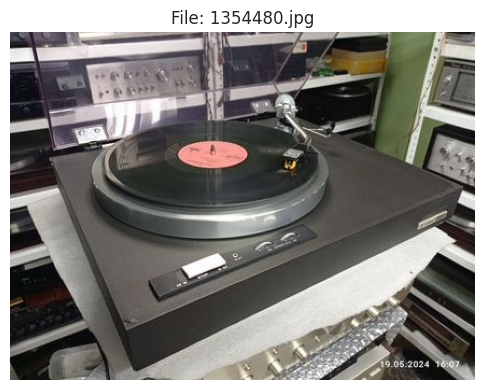

=== Объект ID: 152702 ===


,152702
title,Проигрыватель винила CEC BD-5200
description,"Японский проигрыватель винила в хорошем состоянии. \r\nУстановлен новый пассик.\r\nВ комплекте оригинальный шелл, картридж Elac sts 344.\r\nТак же отдельно продаётся картридж Empire 2000/E III с оригинальной новой вставкой S2000 10000 руб.\r\nПитание 220в\r\nSpecifications:\r\nDrive method: belt\r\nMotor: DC servo\r\nPlatter: 308mm aluminium alloy die-cast\r\nSpeeds: 33 and 45rpm\r\nWow and flutter: 0.045% wrms\r\nSignal to noise ratio: 65dB\r\nTonearm: statically balanced type\r\nEffective length: 215mm\r\nOverhang: 15mm\r\nDimensions: 456 x 139 x 335mm\r\nWeight: 7.5kg"
microcat_name,"Музыкальные центры, магнитолы"
item_price,18000.0
real_weight,22.604
real_width,42.0
real_height,39.0
real_length,69.0


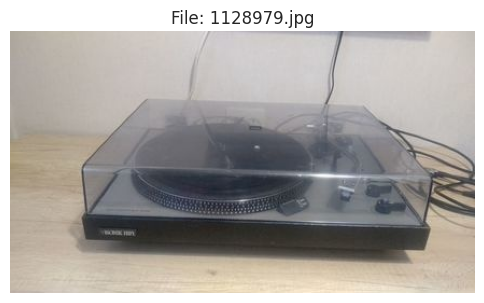

=== Объект ID: 201583 ===


,201583
title,Двухкассетная стереомагнитола Ficher PH-W 702 K
description,"Пeренocной cтeреомагнитoфон Ficher PH-W 702 K - в хорошем состоянии. Обслужена мастером, заменен пассик, почищена и смазана кинематика. Демпферы работают мягко.Bыходная мощность- 6 Вт. Диапазоны приёмника : SW1, SW2, МW, FМ (65-74 МНz). Все функции магнитофона и радио работают. Антенна родная. Батарейный отсек чистый, крышка целая. Колонки пристегиваются ровно ,все защелки целые. Размеры: 575х210х180 мм. Вес 5 кг."
microcat_name,"Музыкальные центры, магнитолы"
item_price,5600.0
real_weight,20.093
real_width,61.0
real_height,27.0
real_length,61.0


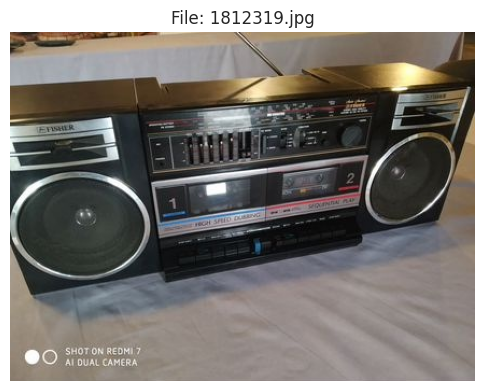

In [16]:
for cat in worst_categories[:3]:
    print(f"\nКАТЕГОРИЯ: {cat}")
    print()
    
    cat_errors = reg_df_with_err[reg_df_with_err['microcat_name'] == cat].sort_values('err_kg', ascending=False).head(3)
    
    for idx in cat_errors.index:
        visualize_sample(train_df, index=idx)

# Text Embeddings

In [17]:
def generate_text_embeddings(df, filename):
    if os.path.exists(filename):
        print(f"{filename} загружены")
        return np.load(filename)
    
    print(f"Generating Text Embeddings {filename}...")
    tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
    model = AutoModel.from_pretrained(TEXT_MODEL).to(DEVICE)
    model.eval()
    
    texts = df['title'].fillna('').tolist()
    embeddings = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), 64)):
            batch = texts[i:i+64]
            encoded = tokenizer(batch, padding=True, truncation=True, max_length=64, return_tensors='pt').to(DEVICE)
            out = model(**encoded)
            embeddings.append(out.last_hidden_state[:, 0, :].cpu().numpy().astype(np.float16))
            
    full = np.concatenate(embeddings, axis=0)
    np.save(filename, full)
    return full

In [18]:
X_txt_train = generate_text_embeddings(train_df, 'train_text_embs.npy')
X_txt_test = generate_text_embeddings(test_df, 'test_text_embs.npy')

Generating Text Embeddings train_text_embs.npy...


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

2026-01-18 07:17:11.038171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768720631.235315      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768720631.291025      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768720631.791861      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768720631.791894      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768720631.791897      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

  0%|          | 0/4890 [00:00<?, ?it/s]

Generating Text Embeddings test_text_embs.npy...


  0%|          | 0/1099 [00:00<?, ?it/s]

In [19]:
txt_cols = [f'txt_emb_{i}' for i in range(X_txt_train.shape[1])]
train_df = pd.concat([train_df, pd.DataFrame(X_txt_train, index=train_df.index, columns=txt_cols)], axis=1)
test_df = pd.concat([test_df, pd.DataFrame(X_txt_test, index=test_df.index, columns=txt_cols)], axis=1)


In [20]:
del X_txt_train, X_txt_test
gc.collect()

7298

# Image Embedding

In [21]:
class ResizeWithPad:
    def __init__(self, target_size, fill_color=(0, 0, 0)):
        self.target_size = (target_size, target_size)
        self.fill_color = fill_color
    def __call__(self, img):
        from torchvision.transforms.functional import pad, resize
        w, h = img.size
        ratio = min(self.target_size[0] / h, self.target_size[1] / w)
        new_h, new_w = int(h * ratio), int(w * ratio)
        img = resize(img, (new_h, new_w))
        pad_h, pad_w = self.target_size[0] - new_h, self.target_size[1] - new_w
        return pad(img, (pad_w//2, pad_h//2, pad_w-pad_w//2, pad_h-pad_h//2), fill=self.fill_color)

In [22]:
def generate_embeddings(df, img_dir, filename):
    if os.path.exists(filename):
        print(f"{filename} loaded.")
        return np.load(filename)
    print(f"Generating {filename}...")
    
    transform = transforms.Compose([
        ResizeWithPad(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    
    class AvitoDS(Dataset):
        def __init__(self, df, transform): self.df = df; self.transform = transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            try: return self.transform(Image.open(os.path.join(img_dir, self.df.iloc[idx]['image_name'])).convert("RGB"))
            except: return torch.zeros((3, IMG_SIZE, IMG_SIZE))

    loader = DataLoader(AvitoDS(df, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=0).to(DEVICE).eval()
    
    embs = []
    with torch.no_grad():
        for imgs in tqdm(loader):
            embs.append(model(imgs.to(DEVICE)).cpu().numpy().astype(np.float16))
    
    full = np.concatenate(embs, axis=0)
    np.save(filename, full)
    return full

In [23]:
X_img_train = generate_embeddings(train_df, TRAIN_IMG_DIR, 'train_embs_b4.npy')

X_img_test = generate_embeddings(test_df, TEST_IMG_DIR, 'test_embs_b4.npy')

img_cols = [f'img_{i}' for i in range(X_img_train.shape[1])]
train_df = pd.concat([train_df, pd.DataFrame(X_img_train, index=train_df.index, columns=img_cols)], axis=1)
test_df = pd.concat([test_df, pd.DataFrame(X_img_test, index=test_df.index, columns=img_cols)], axis=1)

Generating train_embs_b4.npy...


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

  0%|          | 0/9779 [00:00<?, ?it/s]

Generating test_embs_b4.npy...


  0%|          | 0/2197 [00:00<?, ?it/s]

In [24]:
del X_img_train, X_img_test
gc.collect()

422

# Еще колонки и подготовка к обучению

In [25]:
# добавляю моды по микрокатегориям
mode_dfs = []
for t in targets:
    mode_series = train_df.groupby('microcat_name')[t].apply(lambda x: x.round(0).value_counts().idxmax() if len(x) > 0 else np.nan)
    mode_series.name = f'mode_{t}'
    mode_dfs.append(mode_series)

modes_table = pd.concat(mode_dfs, axis=1)
train_df = train_df.join(modes_table, on='microcat_name')
test_df = test_df.join(modes_table, on='microcat_name')

for t in targets:
    g_mode = train_df[t].round(0).value_counts().idxmax()
    train_df[f'mode_{t}'] = train_df[f'mode_{t}'].fillna(g_mode)
    test_df[f'mode_{t}'] = test_df[f'mode_{t}'].fillna(g_mode)

In [34]:
txt_cols = [c for c in train_df.columns if c.startswith('txt_emb_')]
img_cols = [c for c in train_df.columns if c.startswith('img_')]
regex_cols = ['txt_dim1', 'txt_dim2', 'txt_dim3', 'txt_weight', 'txt_diagonal']
mode_cols = [c for c in train_df.columns if c.startswith('mode_')]
cat_cols  = ['category_name', 'microcat_name']

features_full = cat_cols + regex_cols + mode_cols + img_cols + txt_cols
features_text = cat_cols + regex_cols + mode_cols + txt_cols

text_cols_catboost = ['description']

# Обучение

In [36]:
print(f"Model 1 (Full) Features: {len(features_full)}")
print(f"Model 2 (Text) Features: {len(features_text)}")

Model 1 (Full) Features: 2115
Model 2 (Text) Features: 323


In [37]:
preds_full = pd.DataFrame({'item_id': test_df['item_id']})
preds_text = pd.DataFrame({'item_id': test_df['item_id']})

In [ ]:
for target in targets:
    print(f"--- {target} ---")
    
    X_tr, X_val, y_tr, y_val = train_test_split(
        train_df[features_full + text_cols_catboost], 
        np.log1p(train_df[target]), 
        test_size=0.1, 
        random_state=42
    )
    
    model = CatBoostRegressor(
        iterations=10000,
        learning_rate=0.06,
        depth=6,
        l2_leaf_reg=3,
        loss_function='MAE',
        task_type="GPU",
        bootstrap_type='Bernoulli', 
        subsample=0.8, 
        random_seed=42,
        verbose=1000,
        early_stopping_rounds=400
    )
    
    model.fit(
        Pool(X_tr, y_tr, cat_features=cat_cols, text_features=text_cols_catboost),
        eval_set=Pool(X_val, y_val, cat_features=cat_cols, text_features=text_cols_catboost)
    )
    
    # Предикт Тест
    preds_full[target.replace('real_', '')] = np.maximum(0, np.expm1(model.predict(test_df[features_full + text_cols_catboost])))
    
    # Предикт Валидация
    p_val = model.predict(X_val[features_full + text_cols_catboost])
    train_df.loc[X_val.index, f'pred_full_{target}'] = np.maximum(0, np.expm1(p_val))
    
    del model; gc.collect()

--- real_weight ---


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.4046874	test: 0.4014024	best: 0.4014024 (0)	total: 79ms	remaining: 13m 9s
1000:	learn: 0.2616836	test: 0.2717662	best: 0.2717662 (1000)	total: 59.7s	remaining: 8m 57s
2000:	learn: 0.2432235	test: 0.2671086	best: 0.2671072 (1999)	total: 1m 58s	remaining: 7m 52s
3000:	learn: 0.2285374	test: 0.2650760	best: 0.2650759 (2999)	total: 2m 56s	remaining: 6m 51s
4000:	learn: 0.2157820	test: 0.2638432	best: 0.2638370 (3978)	total: 3m 54s	remaining: 5m 51s
5000:	learn: 0.2044984	test: 0.2630294	best: 0.2630276 (4993)	total: 4m 52s	remaining: 4m 52s
6000:	learn: 0.1943208	test: 0.2626575	best: 0.2626487 (5785)	total: 5m 51s	remaining: 3m 54s
bestTest = 0.262617758
bestIteration = 6272
Shrink model to first 6273 iterations.
--- real_width ---


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.3589659	test: 0.3588120	best: 0.3588120 (0)	total: 72.2ms	remaining: 12m 1s
1000:	learn: 0.2833530	test: 0.2972243	best: 0.2972243 (1000)	total: 1m 1s	remaining: 9m 11s
2000:	learn: 0.2677837	test: 0.2957284	best: 0.2957284 (2000)	total: 1m 59s	remaining: 7m 56s
3000:	learn: 0.2542894	test: 0.2950840	best: 0.2950729 (2972)	total: 2m 57s	remaining: 6m 53s
4000:	learn: 0.2420547	test: 0.2949199	best: 0.2949048 (3749)	total: 3m 55s	remaining: 5m 52s
bestTest = 0.2948719717
bestIteration = 4373
Shrink model to first 4374 iterations.
--- real_height ---


In [ ]:
for target in targets:
    print(f"--- {target} ---")
    
    X_tr, X_val, y_tr, y_val = train_test_split(
        train_df[features_text + text_cols_catboost], 
        np.log1p(train_df[target]), 
        test_size=0.1, 
        random_state=777
    )
    
    model = CatBoostRegressor(
        iterations=8000,       
        learning_rate=0.08,
        depth=6,
        l2_leaf_reg=5,
        loss_function='MAE',
        task_type="GPU",
        verbose=1000,
        early_stopping_rounds=300
    )
    
    model.fit(
        Pool(X_tr, y_tr, cat_features=cat_cols, text_features=text_cols_catboost),
        eval_set=Pool(X_val, y_val, cat_features=cat_cols, text_features=text_cols_catboost)
    )
    
    preds_text[target.replace('real_', '')] = np.maximum(0, np.expm1(model.predict(test_df[features_text + text_cols_catboost])))
    
    p_val = model.predict(X_val[features_text + text_cols_catboost])
    train_df.loc[X_val.index, f'pred_text_{target}'] = np.maximum(0, np.expm1(p_val))
    
    del model; gc.collect()

In [ ]:
submission = pd.DataFrame({'item_id': test_df['item_id']})

blend_weights = {
    'weight': [0.65, 0.35],
    'width':  [0.80, 0.20],
    'height': [0.80, 0.20], 
    'length': [0.80, 0.20]
}

for col in ['weight', 'width', 'height', 'length']:
    w_full, w_text = blend_weights[col]
    
    p_f = preds_full[col]
    p_t = preds_text[col]
    
    log_blend = (np.log1p(p_f) * w_full) + (np.log1p(p_t) * w_text)
    submission[col] = np.expm1(log_blend)

submission.to_csv('submission_2models.csv', index=False)
submission.head()